In [ ]:
pip install openai==0.28

In [5]:
import pandas as pd
import numpy as np
import sys
sys.path.append("/Users/rolme/Documents/GitHub/DS_Lab_Project/src/modules")
from SECRETS import OPENAI_API_KEY
from openAI import OpenAI
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("../data/chatgpt_df.csv")
df.head()

,newlabels,text,unikey,word_count,token_count
0,3,Die Rückkehr der PLO\n\nDer Krieg ist noch lan...,10204657208183514369,206,563
1,3,Sind Klimakleber gemeinnützig?\n\nDie Regierun...,2526031540661575257,396,1024
2,3,Ein teures Befriedigend\n\nÖsterreich kommt be...,16957518691286955469,362,1024
3,3,Klimagipfel auf Kollisionskurs\n\nWeder die EU...,4066950822119821616,404,1024
4,3,Was der Justiz fehlt\n\nDie BUWOG zeigt: Bei d...,11134605341473389507,392,1024


In [7]:
gpt = OpenAI(SECRETS.OPENAI_API_KEY)

In [8]:
df_sampled, _ = train_test_split(df, train_size=0.05, random_state=123)

<Axes: title={'center': 'sampled df'}, ylabel='count'>

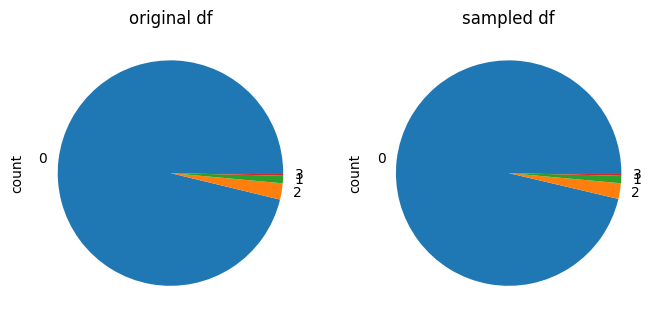

In [10]:
fig, ax = plt.subplots(ncols = 2, figsize=(8,4))

df['newlabels'].value_counts().plot(kind='pie', ax=ax[0], title="original df")
df_sampled['newlabels'].value_counts().plot(kind='pie', ax=ax[1], title="sampled df")

In [11]:
label_counts = df_sampled['newlabels'].value_counts()
label_counts

newlabels
0    8499
2     198
1      93
3      34
Name: count, dtype: int64

In [12]:
def safe_classify(text):
    try:
        return gpt.classify_openai(text)
    except Exception as e:
        print(f"Error classifying text: {text}. Error: {e}")
        return "Error"

df_sampled['classification'] = df_sampled['text'].apply(safe_classify)

In [13]:
label_counts = df_sampled['classification'].value_counts()
label_counts

classification
0     5238
3     2226
1      868
2      491
1.       1
Name: count, dtype: int64

In [15]:
# Ensure 'classification' and 'newlabels' are of the same type
df_sampled['classification'] = df_sampled['classification'].astype(str)
df_sampled['newlabels'] = df_sampled['newlabels'].astype(str)

# Define valid labels
valid_labels = {'0', '1', '2', '3'}

# Filter out rows with invalid 'classification' labels
df_sampled = df_sampled[df_sampled['classification'].isin(valid_labels)]

# Generate the classification report
report = classification_report(df_sampled['newlabels'], df_sampled['classification'], target_names=['0', '1', '2', '3'])

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       1.00      0.62      0.76      8498
           1       0.07      0.67      0.13        93
           2       0.40      0.98      0.56       198
           3       0.01      0.91      0.03        34

    accuracy                           0.63      8823
   macro avg       0.37      0.79      0.37      8823
weighted avg       0.97      0.63      0.75      8823



#### Comparing gpt-3.5 with 4o

In [20]:
# Ensure 'newlabels' column is of type string
df['newlabels'] = df['newlabels'].astype(str)

# Define the number of samples per label
num_samples_per_label = 250

# Define a function to sample data for each label
def sample_data(df, label, num_samples):
    return df[df['newlabels'] == label].sample(n=num_samples, random_state=1)

# Sample data for each label
sampled_0 = sample_data(df, '0', num_samples_per_label)
sampled_1 = sample_data(df, '1', num_samples_per_label)
sampled_2 = sample_data(df, '2', num_samples_per_label)
sampled_3 = sample_data(df, '3', num_samples_per_label)

# Combine the sampled data
compare_df = pd.concat([sampled_0, sampled_1, sampled_2, sampled_3])

# Select only the 'newlabels' and 'text' columns
compare_df = compare_df[['newlabels', 'text']]

In [22]:
compare_df['classification35'] = compare_df['text'].apply(safe_classify)

In [29]:
def safe_classify2(text):
    try:
        return gpt.classify_openai_gpt4o(text)
    except Exception as e:
        print(f"Error classifying text: {text}. Error: {e}")
        return "Error"

compare_df['classification4o'] = compare_df['text'].apply(safe_classify2)

In [31]:
# Ensure 'classification' and 'newlabels' are of the same type
compare_df['classification35'] = compare_df['classification35'].astype(str)
compare_df['classification4o'] = compare_df['classification4o'].astype(str)
compare_df['newlabels'] = compare_df['newlabels'].astype(str)

# Define valid labels
valid_labels = {'0', '1', '2', '3'}

# Filter out rows with invalid 'classification' labels
compare_df_35 = compare_df[compare_df['classification35'].isin(valid_labels)]
compare_df_4o = compare_df[compare_df['classification4o'].isin(valid_labels)]

# Generate the classification report
report_35 = classification_report(compare_df['newlabels'], compare_df_35['classification35'], target_names=['0', '1', '2', '3'])

# Print the classification report
print(report_35)

              precision    recall  f1-score   support

           0       0.89      0.60      0.72       250
           1       0.86      0.63      0.73       250
           2       0.90      0.99      0.94       250
           3       0.61      0.91      0.73       250

    accuracy                           0.78      1000
   macro avg       0.82      0.78      0.78      1000
weighted avg       0.82      0.78      0.78      1000



In [32]:
# Generate the classification report
report_4o = classification_report(compare_df['newlabels'], compare_df_4o['classification4o'], target_names=['0', '1', '2', '3'])

# Print the classification report
print(report_4o)

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       250
           1       0.93      0.81      0.87       250
           2       0.87      1.00      0.93       250
           3       0.91      0.74      0.82       250

    accuracy                           0.86      1000
   macro avg       0.87      0.86      0.86      1000
weighted avg       0.87      0.86      0.86      1000

